# Reading and Processing Physics Data with Spark
# Example notebook to demonstrate the use of Jupyter notebooks, Spark-Root data source, Hadoop-XRootD connector
The example in this notebook is mostly a repackaging of the notebook (https://github.com/vkhristenko/spark-root/blob/master/ipynb/publicCMSMuonia_exampleAnalysis.ipynb) by Viktor Khristenko   
It uses CMS data from the CERN opendata portal (http://opendata.cern.ch)  

Relevant techonology and links:  
[spark-root](https://github.com/diana-hep/spark-root) - Data source for Spark to read data in [ROOT](https://root.cern.ch/) format   
[Hadoop-XRootD connector](https://gitlab.cern.ch/awg/hadoop-xrootd-connector) - this is currently on CERN gitlab, will be made available also on GitHub  
[CMS Big Data project](https://cms-big-data.github.io/)  
[CERN openlab](http://openlab.cern/) data analytics project   

Created: Luca.Canali@cern.ch August 2017

## Prerequisites to set up the environment before starting this

```
export PATH=/opt/anaconda2/bin:$PATH
# this uses a local anaconda installtion for jupyter, python and pyspark installed with pip install
# note, normally we would use the envirnment on cvmfs, but currently it interferes with Hadoop-XRootD to be followed up

source /cvmfs/sft.cern.ch/lcg/etc/hadoop-confext/hadoop-setconf.sh <cluster_name>
# this sets up the YARN cluster variables, use the relevant cluster name

export SPARK_DIST_CLASSPATH=/afs/cern.ch/user/c/canali/public/org.apache.bcel_bcel-6.0.jar     
# this is a temporary workaround till we fix cluster config to remove dependency to flume

kinit
# check that KRB5CCNAME is set to FILE:<path to credentail cache file>

Run the notebook and connect to it, for example by tunneling the port with something like:
ssh -L 8888:localhost:8888 user@jupytermanchine.cern.ch

jupyter notebook --no-browser
```

In [1]:
# This creates the Spark Session with additional packages and environemnt variables
from pyspark.sql import SparkSession

spark=SparkSession.builder \
        .appName("CMS Big Data test notebook") \
        .config("spark.master","yarn") \
        .config("executor-memory","7g") \
        .config("spark.jars.packages", "org.diana-hep:spark-root_2.11:0.1.11,org.diana-hep:histogrammar-sparksql_2.11:1.0.3") \
        .config("spark.yarn.files", "$KRB5CCNAME#krbcache") \
        .config("spark.executorEnv.KRB5CCNAME","'FILE:$PWD/krbcache'") \
        .config("spark.driver.extraClassPath", "/usr/lib/hadoop/EOSfs.jar") \
        .config("spark.executor.extraClassPath", "/usr/lib/hadoop/EOSfs.jar") \
        .getOrCreate()

# The Spark session allocation above relies on the default config of the cluster which uses dynamic allocation 
# you can force allocating a fixed number of executors and cores using something like this example:
# .config("spark.dynamicAllocation.enabled","false").config("num-executors", 8).config("executor-cores", 4) \

In [2]:
# Test that Spark SQL works, debug code, can remove

sql = spark.sql
sql("select 'Hello World!'").show()

+------------+
|Hello World!|
+------------+
|Hello World!|
+------------+



In [3]:
# Example 1: maps the root files stored in HDFS into a Spark Dataframe

df1 = spark.read \
        .format("org.dianahep.sparkroot") \
        .option("tree", "Events") \
        .load("hdfs:/cms/bigdatasci/vkhriste/data/publiccms_muionia_aod/0000/FEEFB039-0978-E011-BB60-E41F131815BC.root")
        
# Note, the example above reads only 1 file
# to read the entire folder, change it to: 
#   load("hdfs:/cms/bigdatasci/vkhriste/data/publiccms_muionia_aod/0000") to read the entire folder

In [4]:
# This is an actions, it reads the file and counts the events
df1.count()

13864

In [5]:
df1.printSchema()

root
 |-- EventAuxiliary: struct (nullable = true)
 |    |-- processHistoryID_: struct (nullable = true)
 |    |    |-- hash_: string (nullable = true)
 |    |-- id_: struct (nullable = true)
 |    |    |-- run_: integer (nullable = true)
 |    |    |-- luminosityBlock_: integer (nullable = true)
 |    |    |-- event_: integer (nullable = true)
 |    |-- processGUID_: string (nullable = true)
 |    |-- time_: struct (nullable = true)
 |    |    |-- timeLow_: integer (nullable = true)
 |    |    |-- timeHigh_: integer (nullable = true)
 |    |-- luminosityBlock_: integer (nullable = true)
 |    |-- isRealData_: boolean (nullable = true)
 |    |-- experimentType_: integer (nullable = true)
 |    |-- bunchCrossing_: integer (nullable = true)
 |    |-- orbitNumber_: integer (nullable = true)
 |    |-- storeNumber_: integer (nullable = true)
 |-- EventBranchEntryInfo: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- branchID_: struct (nullable = true)
 

In [6]:
# Example 2: same as example 1 above, but this time is reads the root files stored in EOS into a Spark Dataframe
# This requires to have the Hadoop-XRootD connector installed on the driver and on the cluster

df2 = spark.read \
        .format("org.dianahep.sparkroot") \
        .option("tree", "Events") \
        .load("root://eospublic.cern.ch://eos/opendata/cms/Run2010B/MuOnia/AOD/Apr21ReReco-v1/0000/FEEFB039-0978-E011-BB60-E41F131815BC.root")
        
# Note, the example above reads only 1 file
# to read the entire folder, change it to: 
#   load("root://eospublic.cern.ch://eos/opendata/cms/Run2010B/MuOnia/AOD/Apr21ReReco-v1/0000/")


In [8]:
# This is an actions, it reads the file and counts the events
df2.count()

13864

In [10]:
# Defines slimmedEvents Dataframe, a projection from the larger Dataframe df2
slimmedEvents = df2.select("recoMuons_muons__RECO_.recoMuons_muons__RECO_obj.reco::RecoCandidate.reco::LeafCandidate")
slimmedEvents.printSchema()

root
 |-- reco::LeafCandidate: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- reco::Candidate: struct (nullable = true)
 |    |    |-- qx3_: integer (nullable = true)
 |    |    |-- pt_: float (nullable = true)
 |    |    |-- eta_: float (nullable = true)
 |    |    |-- phi_: float (nullable = true)
 |    |    |-- mass_: float (nullable = true)
 |    |    |-- vertex_: struct (nullable = true)
 |    |    |    |-- fCoordinates: struct (nullable = true)
 |    |    |    |    |-- fX: float (nullable = true)
 |    |    |    |    |-- fY: float (nullable = true)
 |    |    |    |    |-- fZ: float (nullable = true)
 |    |    |-- pdgId_: integer (nullable = true)
 |    |    |-- status_: integer (nullable = true)
 |    |    |-- cachePolarFixed_: struct (nullable = true)
 |    |    |-- cacheCartesianFixed_: struct (nullable = true)



In [11]:
slimmedEvents.show(2,False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|reco::LeafCandidate                                                                                                                                                                                                                                                                                                                                                                                       |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Example of computation and visualization

In [29]:
from math import *
import numpy
from pyspark.sql import Row

In [30]:
def invariantMass(muon1, muon2):
    pt1 = abs(muon1.pt_)
    phi1 = muon1.phi_
    theta1 = 2.0*atan(exp(-muon1.eta_))
    px1 = pt1 * cos(phi1)
    py1 = pt1 * sin(phi1)
    pz1 = pt1 / tan(theta1)
    E1 = sqrt(px1**2 + py1**2 + pz1**2 + 0.10565836727619171**2)
    #
    pt2 = abs(muon2.pt_)
    phi2 = muon2.phi_
    theta2 = 2.0*atan(exp(-muon2.eta_))
    px2 = pt2 * cos(phi2)
    py2 = pt2 * sin(phi2)
    pz2 = pt2 / tan(theta2)
    E2 = sqrt(px2**2 + py2**2 + pz2**2 + 0.10565836727619171**2)
    #
    return sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)

def handleEvent(event):
    # decreasing order of muon pT
    sortedMuons = sorted(event[0], key=lambda muon: -muon.pt_)
    if len(sortedMuons) < 2:
        return []
    else:
        muon1, muon2 = sortedMuons[:2]
        # return [Row(mass=invariantMass(muon1, muon2), pt1=muon1.pt_, phi1=muon1.phi_, eta1=muon1.eta_, pt2=muon2.pt_, phi2=muon2.phi_, eta2=muon2.eta_)]
        return [invariantMass(muon1, muon2)]

In [31]:
dimuon_masses = slimmedEvents.rdd.flatMap(handleEvent).map(lambda x: (x, )).toDF().persist()

In [32]:
# This is an action and can take a few seconds/minutes depending the data size and number of executors
dimuon_masses.count()

10522

In [34]:
dimuon_masses.show(5)

+-------------------+
|                 _1|
+-------------------+
|  3.120470005927365|
| 6.3942295038213475|
| 3.4798255853479803|
|0.29452593437575375|
|  2.964514468092298|
+-------------------+
only showing top 5 rows



In [35]:
# Setup matpolotlib for plotting
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['fmod', 'sinh', 'trunc', 'tan', 'gamma', 'cosh', 'radians', 'sin', 'expm1', 'ldexp', 'exp', 'frexp', 'ceil', 'copysign', 'isnan', 'cos', 'degrees', 'pi', 'tanh', 'fabs', 'sqrt', 'hypot', 'log', 'log10', 'e', 'log1p', 'floor', 'modf', 'isinf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


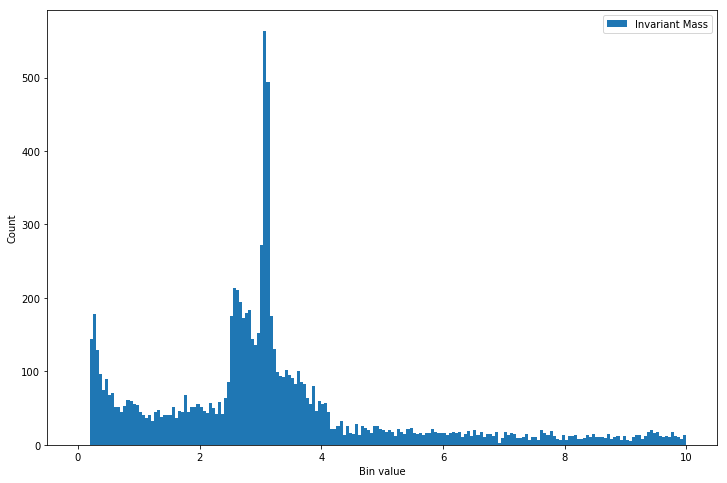

In [39]:
tmpdf = dimuon_masses.toDF("Invariant Mass").limit(1000000)

tmpdf.toPandas().plot.hist(bins=200, range=[0, 10])
xlabel('Bin value')
ylabel('Count');